# XMM-Newton Timing Analysis: CTCV J2056-3014
### *To view plots, visit [nbviewer](https://nbviewer.org/github/ericymiao/ctcvj2056-timing-spin-evolution/blob/main/notebooks/02_xmm_timing.ipynb)*

Period searches for 2019 and 2022 XMM-Newton observations.

## XMM-Newton-Specific Notes

XMM-Newton carries three co-aligned X-ray telescopes with CCD cameras: one PN (higher effective area, faster readout) and two MOS detectors (MOS1, MOS2). Key considerations:

- **Separate detector analysis**: Each detector (PN, MOS1, MOS2) must be analyzed independently due to different effective areas, backgrounds, and timing properties. Results can be combined afterward.
- **Background extraction**: Unlike NICER's model-based background, XMM uses **circular extraction regions** on the detector. Source counts come from a region centered on the target; background from a source-free region on the same chip. The background must be scaled by the ratio of extraction areas.
- **PN dominates**: The PN detector typically provides ~2-3x more counts than each MOS due to its larger effective area, especially important for timing analysis.

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../src')

import numpy as np
from stingray import EventList, Lightcurve
from stingray.pulse import z_n_search
from astropy.time import Time, TimeDelta
import hendrics.io as HENio

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from timing_analysis import *
from statistics import *

plt.rcParams.update({
    'font.size': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'figure.constrained_layout.use': True,
})

savedir = '../paper_figures'

## Load Data

In [3]:
events = {
    '0842570101': {'pn':{'src':{}, 'bkg':{}}, 'mos1':{'src':{}, 'bkg':{}}, 'mos2':{'src':{}, 'bkg':{}}},
    '0902500101': {'pn':{'src':{}, 'bkg':{}}, 'mos1':{'src':{}, 'bkg':{}}, 'mos2':{'src':{}, 'bkg':{}}},
}

data_path = '../../../xmm'

for obs in events:
    for module in ['pn', 'mos1', 'mos2']:
        events[obs][module]['src']['total'] = HENio.load_events(f'{data_path}/{obs}/{module}_clean_src.evt')
        events[obs][module]['bkg']['total'] = HENio.load_events(f'{data_path}/{obs}/{module}_clean_bkg.evt')

# Energy filtering
for obs in events:
    for module in events[obs]:
        for region in events[obs][module]:
            events[obs][module][region]['total'].filter_energy_range([0.3, 10], inplace=True)
            events[obs][module][region]['soft'] = events[obs][module][region]['total'].filter_energy_range([0.3, 2])
            events[obs][module][region]['hard'] = events[obs][module][region]['total'].filter_energy_range([2, 10])

# Create lightcurves
lightcurves = {}
for obs in events:
    lightcurves[obs] = {}
    for module in events[obs]:
        lightcurves[obs][module] = {}
        for region in events[obs][module]:
            lightcurves[obs][module][region] = {}
            for energy in events[obs][module]['src']:
                lightcurves[obs][module][region][energy] = {}
                for dt in [1, 5, 20, 50]:
                    lightcurves[obs][module][region][energy][dt] = events[obs][module][region][energy].to_lc(dt=dt)

/opt/miniconda3/envs/CTCV_PINT/lib/python3.13/site-packages/stingray/io.py:1044: UserWarning: No valid GTI extensions found. 
Error: list index out of range
GTIs will be set to the entire time series.
  warnings.warn(


## Observation Summary

In [4]:
print("XMM OBSERVATION SUMMARY\n")

for obs in events:
    factor = (27**2)/(357**2) if obs == '0842570101' else (20**2)/(113**2)
    
    print(f"OBSERVATION: {obs}")
    
    total_src_counts = 0
    total_bkg_scaled = 0
    total_net_counts = 0
    total_net_rate = 0
    total_time_avg = 0
    
    for module in events[obs]:
        src_counts = len(events[obs][module]['src']['total'].time)
        bkg_counts = len(events[obs][module]['bkg']['total'].time)
        bkg_scaled = bkg_counts * factor
        net_source = src_counts - bkg_scaled
        
        total_time = np.sum(events[obs][module]['src']['total'].gti[:, 1] - events[obs][module]['src']['total'].gti[:, 0])
        
        print(f"  {module.upper():4s}  Time: {total_time/1000:6.2f} ks  |  Source: {src_counts:7,.0f}  Bkg: {bkg_scaled:7.1f}  Net: {net_source:7.1f}")
        
        total_src_counts += src_counts
        total_bkg_scaled += bkg_scaled
        total_net_counts += net_source
        total_time_avg += total_time
    
    avg_time = total_time_avg / len(events[obs])
    print(f"  TOTAL Time: {avg_time/1000:6.2f} ks  |  Source: {total_src_counts:7,.0f}  Bkg: {total_bkg_scaled:7.1f}  Net: {total_net_counts:7.1f}")
    print()

XMM OBSERVATION SUMMARY

OBSERVATION: 0842570101
  PN    Time:  15.55 ks  |  Source:   5,179  Bkg:    77.5  Net:  5101.5
  MOS1  Time:  17.60 ks  |  Source:   2,930  Bkg:    26.8  Net:  2903.2
  MOS2  Time:  17.58 ks  |  Source:   3,038  Bkg:     8.5  Net:  3029.5
  TOTAL Time:  16.91 ks  |  Source:  11,147  Bkg:   112.8  Net: 11034.2

OBSERVATION: 0902500101
  PN    Time:  51.16 ks  |  Source:  15,380  Bkg:   128.3  Net: 15251.7
  MOS1  Time:  52.99 ks  |  Source:   5,945  Bkg:    97.9  Net:  5847.1
  MOS2  Time:  52.98 ks  |  Source:   6,203  Bkg:    91.0  Net:  6112.0
  TOTAL Time:  52.38 ks  |  Source:  27,528  Bkg:   317.2  Net: 27210.8



## Lightcurve Visualization

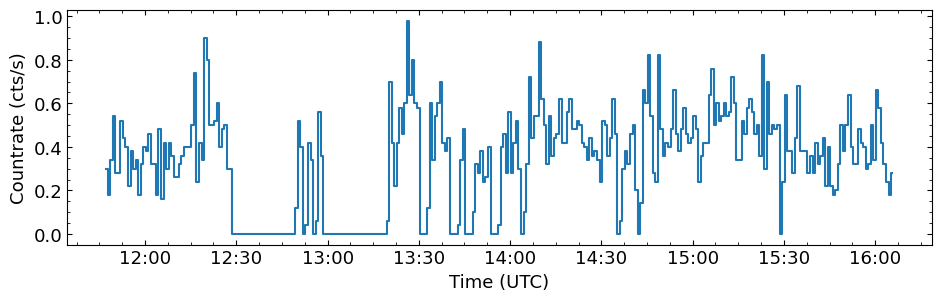

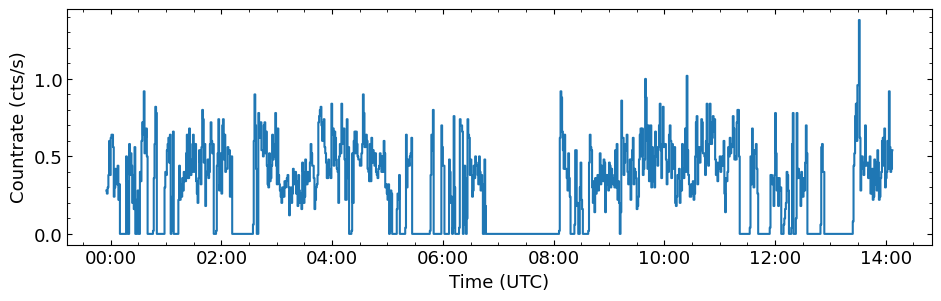

In [5]:
binsize = 50
obs_labels = {'0842570101': '2019', '0902500101': '2022'}

for obs in lightcurves:
    lc = lightcurves[obs]['pn']['src']['total'][binsize]
    lc_time = np.asarray(lc.time, dtype=np.float64)
    lc_countrate = np.asarray(lc.countrate, dtype=np.float64)
    
    fig, ax = plt.subplots(figsize=(9.3, 2.9))
    
    gti = np.asarray(lc.gti, dtype=np.float64) if lc.gti is not None else None
    if gti is not None:
        for gti_start, gti_stop in gti:
            mask = (lc_time >= gti_start) & (lc_time <= gti_stop)
            if not np.any(mask):
                continue
            t = Time(lc.mjdref, format='mjd') + TimeDelta(lc_time[mask], format='sec')
            x = t.to_datetime()
            ax.step(x, lc_countrate[mask], where='mid', color='#1F77B4', lw=1.5)
    else:
        t = Time(lc.mjdref, format='mjd') + TimeDelta(lc_time, format='sec')
        x = t.to_datetime()
        cr = np.where(lc_countrate == 0, np.nan, lc_countrate)
        ax.step(x, cr, where='mid', color='#1F77B4', lw=1.5)
    
    ax.set_xlabel('Time (UTC)')
    ax.set_ylabel('Countrate (cts/s)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    fig.savefig(f'{savedir}/xmm_lc_{obs_labels[obs]}.pdf')
    plt.show()

## Z^2 Periodogram

Period search using the Z^2 statistic on unbinned event times. Each detector module is analyzed separately to verify consistent period detection across all three cameras.

Observation: 0842570101, module: pn
FREQUENCY RESULTS:
  Peak:        3.376764346764347e-02 Hz
  Uncertainty: +1.422466e-05 / -1.416361e-05 Hz

PERIOD RESULTS:
  Peak:        2.961414825876764e+01 s
  Uncertainty: +1.242667e-02 / -1.246975e-02 s
Observation: 0842570101, module: mos1
FREQUENCY RESULTS:
  Peak:        3.377148962148962e-02 Hz
  Uncertainty: +1.471306e-05 / -1.599512e-05 Hz

PERIOD RESULTS:
  Peak:        2.961077557454486e+01 s
  Uncertainty: +1.403113e-02 / -1.289477e-02 s
Observation: 0842570101, module: mos2
FREQUENCY RESULTS:
  Peak:        3.377808302808303e-02 Hz
  Uncertainty: +1.416361e-05 / -1.568987e-05 Hz

PERIOD RESULTS:
  Peak:        2.960499561708703e+01 s
  Uncertainty: +1.375786e-02 / -1.240858e-02 s


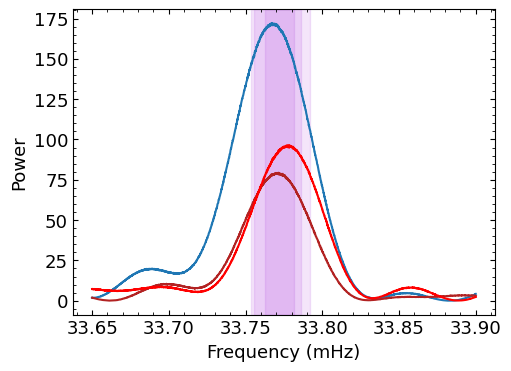

Observation: 0902500101, module: pn
FREQUENCY RESULTS:
  Peak:        3.377356532356533e-02 Hz
  Uncertainty: +2.686203e-06 / -3.479853e-06 Hz

PERIOD RESULTS:
  Peak:        2.960895571490805e+01 s
  Uncertainty: +3.051068e-03 / -2.354780e-03 s
Observation: 0902500101, module: mos1
FREQUENCY RESULTS:
  Peak:        3.377393162393162e-02 Hz
  Uncertainty: +3.968254e-06 / -3.724054e-06 Hz

PERIOD RESULTS:
  Peak:        2.960863458642811e+01 s
  Uncertainty: +3.265131e-03 / -3.478445e-03 s
Observation: 0902500101, module: mos2
FREQUENCY RESULTS:
  Peak:        3.377277167277167e-02 Hz
  Uncertainty: +4.151404e-06 / -3.724054e-06 Hz

PERIOD RESULTS:
  Peak:        2.960965151717830e+01 s
  Uncertainty: +3.265355e-03 / -3.639219e-03 s


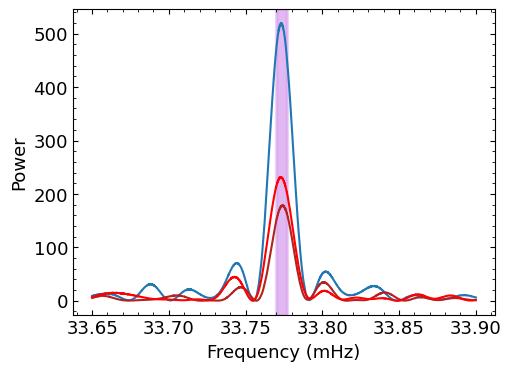

In [6]:
f_min, f_max = 0.03365, 0.0339
frequencies = np.linspace(f_min, f_max, 4096)
nharm = 1

Z2 = {}
obs_labels_z2 = {'0842570101': '2019', '0902500101': '2022'}

for obs in lightcurves:
    Z2[obs] = {}
    fig, ax = plt.subplots(figsize=(5, 3.6))
    
    for module in lightcurves[obs]:
        #fig, ax = plt.subplots(figsize=(5, 3.6))
        
        if module == 'pn':
            color = '#1F77B4'
        elif module == 'mos1':
            color = 'firebrick'
        elif module == 'mos2':
            color = 'red'
        
        evt = events[obs][module]['src']['total']
        frequency, power = z_n_search(evt.time, frequencies, nharm=nharm)
        Z2[obs][module] = (frequency, power)
        
        ax.plot(frequency*1e3, power, lw=1.5, color=color)
        
        peak_freq = frequencies[np.argmax(power)]
        peak_power = power[np.argmax(power)]
        
        print(f"Observation: {obs}, module: {module}")
        freq_min, freq_max, power_min, _ = get_frequency_uncertainty(
            frequencies, power, peak_freq, peak_power, nharm, 1
        )
        
        ax.axvspan(freq_min*1e3, freq_max*1e3, alpha=0.10, color='darkviolet')
        #ax.axhline(power_min, alpha=0.8, color='darkviolet', ls='--')
        
        ax.set_xlabel('Frequency (mHz)')
        ax.set_ylabel('Power')
        ax.ticklabel_format(axis='x', useOffset=False)
        
        fig.savefig(f'{savedir}/xmm_z2_{obs_labels_z2[obs]}_{module}.pdf')
    plt.show()

## Folded Profiles

Phase-folded lightcurves with background subtracted using the area scaling factors. The PN detector provides the best statistics for pulse profile analysis.

In [12]:
ephemeris = 58780
P_orb = 29.60968584
n_bins = 20

# Background scaling factors
bkg_factors = {
    '0842570101': (27**2)/(357**2),
    '0902500101': (20**2)/(113**2)
}

# Fold lightcurves
folded_lightcurves = {}
for obs in lightcurves:
    folded_lightcurves[obs] = {}
    for module in lightcurves[obs]:
        folded_lightcurves[obs][module] = {}
        for region in lightcurves[obs][module]:
            folded_lightcurves[obs][module][region] = {}
            for energy in events[obs][module]['src']:
                folded_lightcurves[obs][module][region][energy] = fold(
                    events[obs][module][region][energy], P_orb, ephemeris, n_bins
                )

# Background subtraction
for obs in folded_lightcurves:
    factor = bkg_factors[obs]
    for module in folded_lightcurves[obs]:
        for energy in folded_lightcurves[obs][module]['src']:
            _, _, bkg_cr, bkg_err, _ = folded_lightcurves[obs][module]['bkg'][energy]
            phase, counts, cr, err, other = folded_lightcurves[obs][module]['src'][energy]
            new_cr = cr - bkg_cr * factor
            new_err = np.sqrt(err**2 + (bkg_err * factor)**2)
            folded_lightcurves[obs][module]['src'][energy] = (phase, counts, new_cr, new_err, other)

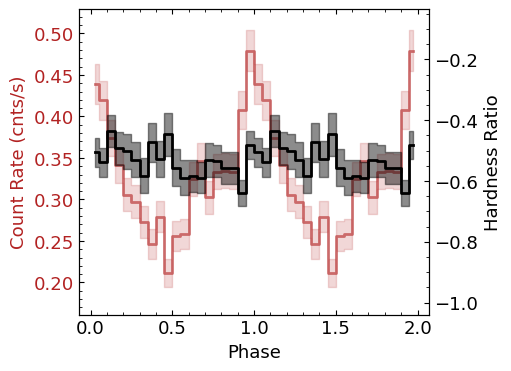

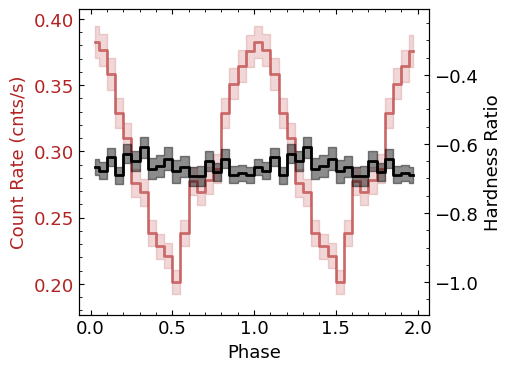

In [19]:
# Plot folded lightcurves with hardness ratios
HR = {}
HR_error = {}
obs_labels_fold = {'0842570101': '2019', '0902500101': '2022'}

for obs in folded_lightcurves:
    HR[obs] = {}
    HR_error[obs] = {}
    
    phase, _, cr, err, _ = folded_lightcurves[obs]['pn']['src']['total']
    _, _, soft_cr, soft_err, _ = folded_lightcurves[obs]['pn']['src']['soft']
    _, _, hard_cr, hard_err, _ = folded_lightcurves[obs]['pn']['src']['hard']
    
    # Phase centers and extension to [0,2]
    phase_centers = phase[1:] - np.diff(phase) / 2
    ext_phase = np.concatenate([phase_centers, phase_centers + 1])
    ext_cr = np.concatenate([cr, cr])
    ext_err = np.concatenate([err, err])
    
    # --- Dual-axis: flux + HR ---
    fig, ax = plt.subplots(figsize=(5, 3.6))
    
    ax.step(ext_phase, ext_cr, where='mid', color='firebrick', lw=2, alpha=0.6)
    ax.fill_between(ext_phase, ext_cr - ext_err, ext_cr + ext_err,
                    step='mid', color='firebrick', alpha=0.18)
    ax.set_xlabel('Phase')
    ax.set_ylabel('Count Rate (cnts/s)', color='firebrick')
    ax.tick_params(axis='y', labelcolor='firebrick')
    
    rate_min = np.min(cr) - 2 * np.max(err)
    rate_max = np.max(cr) + 2 * np.max(err)
    ax.set_ylim(rate_min, rate_max)
    
    # Hardness ratio
    hr = (hard_cr - soft_cr) / (hard_cr + soft_cr)
    hr_err = (2 * np.sqrt(hard_cr**2 * soft_err**2 + soft_cr**2 * hard_err**2)) / (hard_cr + soft_cr)**2
    HR[obs] = hr
    HR_error[obs] = hr_err
    
    ext_hr = np.concatenate([hr, hr])
    ext_hr_err = np.concatenate([hr_err, hr_err])
    
    ax2 = ax.twinx()
    ax2.step(ext_phase, ext_hr, where='mid', color='black', lw=2)
    ax2.fill_between(ext_phase, ext_hr - ext_hr_err, ext_hr + ext_hr_err,
                     step='mid', color='black', alpha=0.45)
    ax2.set_ylabel('Hardness Ratio')
    
    hr_min = np.min(hr) - 2 * 0.2
    hr_max = np.max(hr) + 2 * 0.2
    ax2.set_ylim(hr_min, hr_max)
    
    fig.savefig(f'{savedir}/xmm_folded_hr_{obs_labels_fold[obs]}.pdf')
    plt.show()

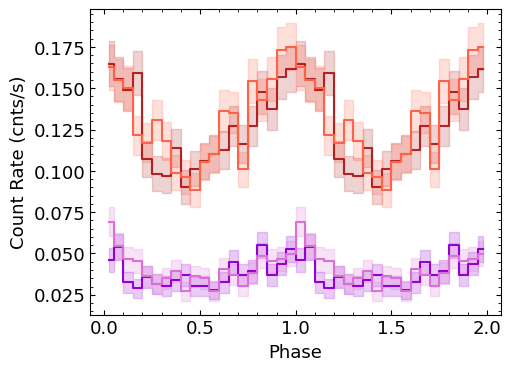

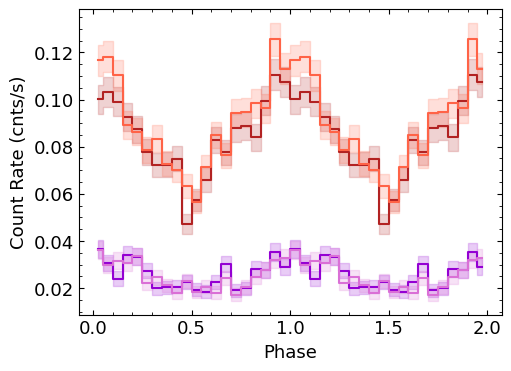

In [39]:
# Plot folded lightcurves: soft + hard separately
obs_labels_fold = {'0842570101': '2019', '0902500101': '2022'}

for obs in folded_lightcurves:
    fig, ax = plt.subplots(figsize=(5, 3.6))
    for energy in ['soft', 'hard']:

        for module in folded_lightcurves[obs]:
            if module == 'pn': continue

            if energy == 'soft':
                if module == 'pn': color = 'firebrick'
                elif module == 'mos1': color = 'firebrick'
                elif module == 'mos2': color = 'tomato'
            elif energy == 'hard':
                if module == 'pn': color = 'darkviolet'
                elif module == 'mos1': color = 'darkviolet'
                elif module == 'mos2': color = 'orchid'

            phase, _, cr, err, _ = folded_lightcurves[obs][module]['src'][energy]

            phase_centers = phase[1:] - np.diff(phase) / 2
            ext_phase = np.concatenate([phase_centers, phase_centers + 1])

            ext = np.concatenate([cr, cr])
            ext_err = np.concatenate([err, err])

            ax.step(ext_phase, ext, where='mid', color=color, lw=1.5)
            ax.fill_between(ext_phase, ext - ext_err, ext + ext_err,
                            step='mid', color=color, alpha=0.2)

            #ax.set_ylim(top=1.1*np.max(soft_cr))
            ax.set_xlabel('Phase')
            ax.set_ylabel('Count Rate (cnts/s)')

            fig.savefig(f'{savedir}/xmm_folded_softhard_{obs_labels_fold[obs]}.pdf')
    plt.show()

## Statistical Tests

### F-test for Hardness Ratio Variability

Testing whether the hardness ratio varies sinusoidally with pulse phase. The null hypothesis assumes constant HR; the alternative fits a sinusoid. A significant F-statistic indicates genuine spectral variability with phase.

### Phase Correlation Test

Determines whether HR is correlated or anticorrelated with flux (i.e., does the source harden when brighter or fainter?).

In [15]:
observations = ['0842570101', '0902500101']
obs_names = ['2019', '2022']

print("F-TEST FOR HARDNESS RATIO VARIABILITY\n")

for obs, obs_name in zip(observations, obs_names):
    print(f"OBSERVATION: {obs_name}")
    result = test_hardness_ratio_variability(HR[obs], HR_error[obs])
    print()

F-TEST FOR HARDNESS RATIO VARIABILITY

OBSERVATION: 2019

Model 1 (Constant): chi2 = 18.35, dof = 19, chi2_red = 0.97
Model 2 (Sinusoid): chi2 = 13.65, dof = 17, chi2_red = 0.80
  Offset: -0.5362 +/- 0.0122
  Amplitude: 0.0371 +/- 0.0171
  Phase shift: 0.035 cycles

F-test: F = 2.93, p = 8.07e-02, 1.7 sigma
Result: No significant improvement

OBSERVATION: 2022

Model 1 (Constant): chi2 = 14.57, dof = 19, chi2_red = 0.77
Model 2 (Sinusoid): chi2 = 11.45, dof = 17, chi2_red = 0.67
  Offset: -0.6662 +/- 0.0062
  Amplitude: 0.0155 +/- 0.0088
  Phase shift: -0.065 cycles

F-test: F = 2.32, p = 1.29e-01, 1.5 sigma
Result: No significant improvement



In [16]:
print("PHASE CORRELATION TEST: HARDNESS RATIO vs FLUX\n")

for obs, obs_name in zip(observations, obs_names):
    print(f"OBSERVATION: {obs_name}")
    _, _, flux_data, flux_errors, _ = folded_lightcurves[obs]['pn']['src']['total']
    result = test_phase_correlation(flux_data, flux_errors, HR[obs], HR_error[obs])
    print()

PHASE CORRELATION TEST: HARDNESS RATIO vs FLUX

OBSERVATION: 2019

HR amplitude: 0.0371 +/- 0.0171 (2.2 sigma)
Flux amplitude: 0.0820 +/- 0.0065 (12.6 sigma)

Flux max at phase: 0.976 +/- 0.0125
HR max at phase: 0.215 +/- 0.0734
Phase difference: 0.238 +/- 0.0745 cycles

Deviation from in-phase (delta_phi=0): 3.2 sigma
Deviation from anticorr (|delta_phi|=0.5): 3.5 sigma
Result: Intermediate phase shift

OBSERVATION: 2022

HR amplitude: 0.0155 +/- 0.0088 (1.8 sigma)
Flux amplitude: 0.0775 +/- 0.0034 (22.8 sigma)

Flux max at phase: 1.000 +/- 0.0070
HR max at phase: 0.315 +/- 0.0889
Phase difference: 0.316 +/- 0.0891 cycles

Deviation from in-phase (delta_phi=0): 3.5 sigma
Deviation from anticorr (|delta_phi|=0.5): 2.1 sigma
Result: ANTICORRELATED - HR max aligns with flux min

